# Configurações iniciais

**Conectando ao google drive**


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


**Checando a versão da GPU**

In [3]:
!nvidia-smi

Wed Feb 23 11:47:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Clonando o repositório da Yolov5**

In [4]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10956, done.
remote: Total 10956 (delta 0), reused 0 (delta 0), pack-reused 10956
Receiving objects: 100% (10956/10956), 11.05 MiB | 21.76 MiB/s, done.
Resolving deltas: 100% (7571/7571), done.


**Instalando os requerimentos**

In [5]:
!pip install -r yolov5/requirements.txt

     |████████████████████████████████| 596 kB 8.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Treinamento Localização do Indicador

**Arquivo de configuração da arquitetura do modelo**

In [ ]:
with open('new_train_yaml', 'w+') as file:
    file.write(
        """
        # parameters
        nc: 1  # number of classes
        depth_multiple: 0.33  # model depth multiple
        width_multiple: 0.50  # layer channel multiple

        # anchors
        anchors:
          - [10,13, 16,30, 33,23]  # P3/8
          - [30,61, 62,45, 59,119]  # P4/16
          - [116,90, 156,198, 373,326]  # P5/32

        # YOLOv5 backbone
        backbone:
          # [from, number, module, args]
          [[-1, 1, Focus, [64, 3]],  # 0-P1/2
           [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
           [-1, 3, BottleneckCSP, [128]],
           [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
           [-1, 9, BottleneckCSP, [256]],
           [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
           [-1, 9, BottleneckCSP, [512]],
           [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
           [-1, 1, SPP, [1024, [5, 9, 13]]],
           [-1, 3, BottleneckCSP, [1024, False]],  # 9
          ]

        # YOLOv5 head
        head:
          [[-1, 1, Conv, [512, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 6], 1, Concat, [1]],  # cat backbone P4
           [-1, 3, BottleneckCSP, [512, False]],  # 13

           [-1, 1, Conv, [256, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 4], 1, Concat, [1]],  # cat backbone P3
           [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

           [-1, 1, Conv, [256, 3, 2]],
           [[-1, 14], 1, Concat, [1]],  # cat head P4
           [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

           [-1, 1, Conv, [512, 3, 2]],
           [[-1, 10], 1, Concat, [1]],  # cat head P5
           [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

           [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
          ]
        """
    )

**Renomeando os arquivos com as labels**

Os arquivos estão com o formato ".xml.txt" sendo necessária a correção.

In [ ]:
import glob
import os
x = '.txt'
txtlist = glob.glob("/content/drive/MyDrive/Estudo/Yolov5/indicador/data/labels/train/*{}".format(x),recursive=False)
txtlist2 = glob.glob("/content/drive/MyDrive/Estudo/Yolov5/indicador/data/labels/valid/*{}".format(x),recursive=False)

for x in txtlist:
  os.rename(x, x.replace('.xml', ''))

for y in txtlist2:
  os.rename(y, y.replace('.xml', ''))

**Arquivo de configuração do treinamento**

In [ ]:
with open('new_data_yaml', 'w+') as file:
    file.write(
        """
        train: /content/drive/MyDrive/Estudo/Yolov5/indicador/data/images/train/
        val: /content/drive/MyDrive/Estudo/Yolov5/indicador/data/images/valid/

        nc: 1
        names: ['Indicador']
        """
    )

**Realizando o treinamento**

In [ ]:
!python /content/yolov5/train.py --img 416 --batch 16 --epochs 500 --data /content/new_data_yaml --cfg /content/new_train_yaml


train: weights=yolov5/yolov5s.pt, cfg=/content/new_train_yaml, data=/content/new_data_yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=500, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-0-g3752807 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=

**Visualizando as informações de treinamento**

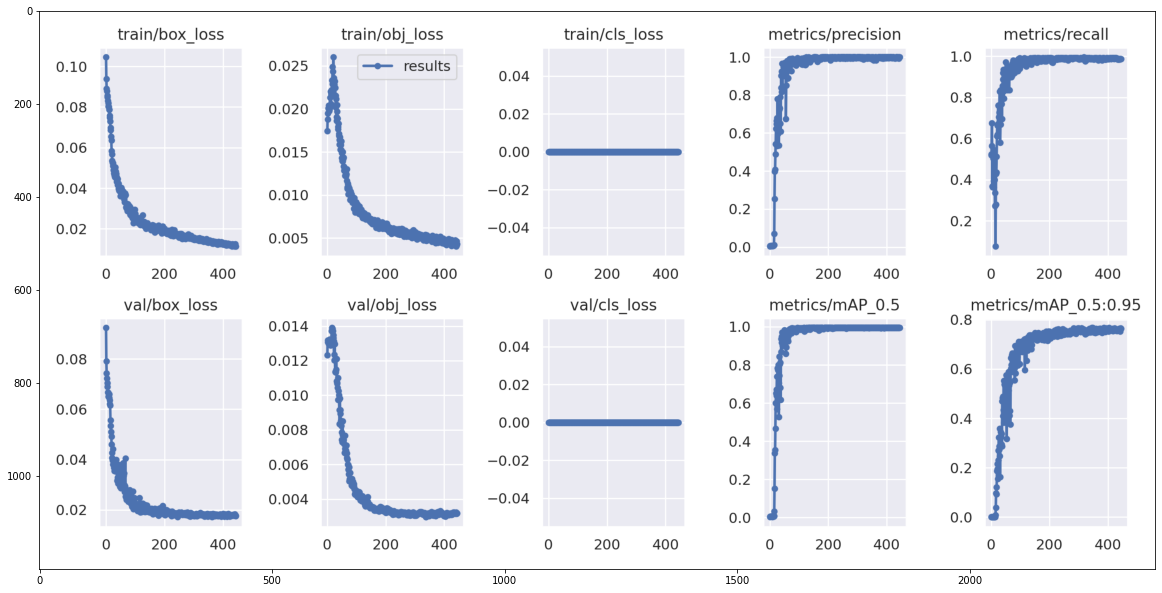

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Obs: Existem outras informações da etapa de treinamento na pasta
img = mpimg.imread("/content/yolov5/runs/train/exp/results.png")
plt.figure(figsize=(20,30))
plt.imshow(img)

# Teste

**Testando o modelo**

In [12]:
!python /content/yolov5/detect.py --source /content/drive/MyDrive/Estudo/Yolov5/indicador/data/images/valid/1010265487.jpg --weights '/content/drive/MyDrive/Estudo/Yolov5/indicador/outputs/best.pt' --img 416 --conf 0.5 --save-txt  --save-crop 


usage: detect.py [-h] [--weights WEIGHTS [WEIGHTS ...]] [--source SOURCE]
                 [--data DATA] [--imgsz IMGSZ [IMGSZ ...]]
                 [--conf-thres CONF_THRES] [--iou-thres IOU_THRES]
                 [--max-det MAX_DET] [--device DEVICE] [--view-img]
                 [--save-txt] [--save-conf] [--save-crop] [--nosave]
                 [--classes CLASSES [CLASSES ...]] [--agnostic-nms]
                 [--augment] [--visualize] [--update] [--project PROJECT]
                 [--name NAME] [--exist-ok] [--line-thickness LINE_THICKNESS]
                 [--hide-labels] [--hide-conf] [--half] [--dnn]
detect.py: error: unrecognized arguments: /content/drive/MyDrive/Estudo/Yolov5/


**Resultado obtido**